In [7]:
#####################
import numpy as np
from pylab import *

#import scipy
from scipy import ndimage
#from scipy import math
from scipy import signal
import scipy.ndimage as ndi
from scipy.stats.stats import pearsonr
from scipy.io import netcdf  
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline


import math

import matplotlib.dates as mdates
import matplotlib.ticker as ticker




In [3]:
def interpid2(sal0,z,resolution):

    znew=np.linspace(z[0],z[-1],resolution)
    znew=np.interp(znew,z,z)
    
    nani=sum(~np.isnan(sal0))
    print(nani)
    
    if nani==len(z):
        cs=CubicSpline(z,sal0)
        datax=cs(znew)
    
    else:
        idx1,=np.where(znew<=z[nani])
        znew1=znew[:idx1[-1]]
        
        cs=CubicSpline(z[:nani],sal0[:nani])
        data=cs(znew1)
        
        rest=resolution-(int(z[nani])-2)
        
        nany=np.repeat(nan,rest)
        
        datax=np.append(data,nany)
    
    return datax,znew

In [ ]:
pname='./'
fname='EN.4.2.1.f.analysis.g10.200708_2.nc' # Donnee ci-joint (sample)

####

minlon,maxlon,minlat,maxlat=[-60.,30.,-45.,0.]

######################

nc=netcdf.netcdf_file(pname+fname)

lat=nc.variables['lat'][:]
lon=nc.variables['lon'][:]
ilat,=np.where((lat>=minlat)&(lat<=maxlat))
ilon,=np.where((lon>=minlon)&(lon<=maxlon))
lon=lon[ilon[0]:ilon[-1]+1]
lat=lat[ilat[0]:ilat[-1]+1]

z=nc.variables['depth'][:]

temp=nc.variables['temperature'][0,:,ilat[0]:ilat[-1]+1,ilon[0]:ilon[-1]+1]-273. 

sal=nc.variables['salinity'][0,:,ilat[0]:ilat[-1]+1,ilon[0]:ilon[-1]+1] 

nc.close()

######################

sal0=np.array(sal)

In [129]:
########################################################################
########## La fonction qui interpole et evite les NaN ##################
########################################################################


def interpid22(sal0,z,znew):
    
    nani=sum(~np.isnan(sal0))               # Detect les donnees valides sans NaN
    
    if nani==len(z):                        # Si tout la colonne n'a pas de NaN
        cs=CubicSpline(z,sal0)
        datax=cs(znew)
    
    else:                                   # Si la colonne a du NaN: interpolation partielle
        idx1,=np.where(znew<=z[nani])
        znew1=znew[:idx1[-1]]
        
        cs=CubicSpline(z[:nani],sal0[:nani])
        datax=cs(znew1)
    
    return datax


########################################################################

In [132]:
%%time

resolution = 10000
znew=np.linspace(z[0],z[-1],resolution) # Je construit le nouveau Z (de 42 a 5350)


heave=np.ma.masked_all((resolution,len(lat),len(lon)))


for i in range(len(lat)):
    print(i)
    for j in range(len(lon)):
        try:
            data=interpid22(sal0[:,i,j],z,znew)
            dataNan=np.repeat(np.nan,(resolution-len(data)))            # J'ajoute NaN au reste de l'espace du mask array 
            data1=np.hstack((data,dataNan))                                # Puis combiner avec le donnee interpole combler le 5350 vertical spacing
            heave[:,i,j]=data1
        except:
            None


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
CPU times: user 1.92 s, sys: 315 ms, total: 2.24 s
Wall time: 2.25 s


<ipython-input-133-fa0685476532>:2: RuntimeWarning: Mean of empty slice
  heavem=np.nanmean(np.nanmean(heave,axis=1),axis=1)
<ipython-input-133-fa0685476532>:8: RuntimeWarning: Mean of empty slice
  grad0 = np.gradient(np.nanmean(np.nanmean(sal0,axis=1),axis=1),-z)
<ipython-input-133-fa0685476532>:11: RuntimeWarning: Mean of empty slice
  gradm=np.nanmean(np.nanmean(np.gradient(heave,-znew,axis=0),axis=1),axis=1)
<ipython-input-133-fa0685476532>:12: RuntimeWarning: Mean of empty slice
  grad0m = np.nanmean(np.nanmean(np.gradient(sal0,-z,axis=0),axis=1),axis=1)
<ipython-input-133-fa0685476532>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  subplot(235)


Text(0.5, 1.0, 'Pdf of Gradient')

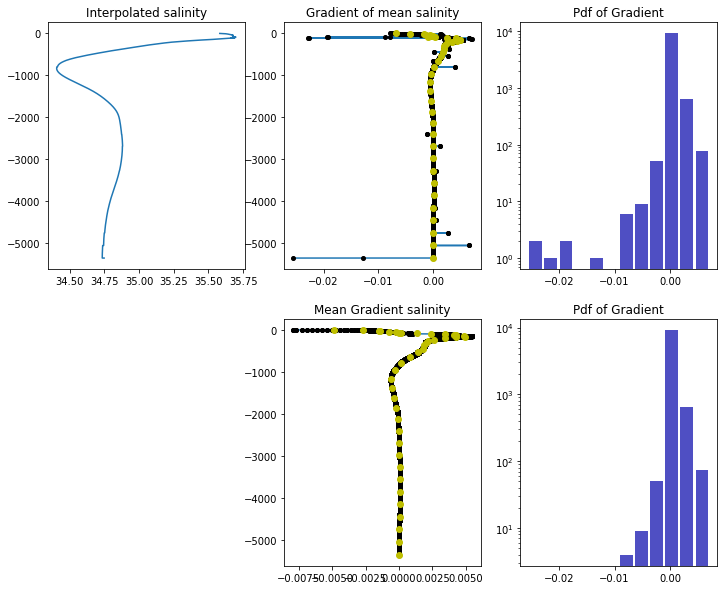

In [133]:



########################################################################
heavem=np.nanmean(np.nanmean(heave,axis=1),axis=1)

########################################################################

# Gradient of the mean salinity
grad=np.gradient(heavem,-znew)
grad0 = np.gradient(np.nanmean(np.nanmean(sal0,axis=1),axis=1),-z)
            
# Mean of the salinity Gradient
gradm=np.nanmean(np.nanmean(np.gradient(heave,-znew,axis=0),axis=1),axis=1)
grad0m = np.nanmean(np.nanmean(np.gradient(sal0,-z,axis=0),axis=1),axis=1)

########################################################################


########################################################################
# ~ print(znew.shape)
# ~ print(heave.shape)
# ~ stop

fig=plt.figure(figsize=(12.,10.))

subplot(231)
plot(heavem,znew*-1)
# ~ plot(heave,znew*-1,'ro',ms=4)

plt.title('Interpolated salinity')

subplot(232)
plot(grad,znew*-1)
plot(grad,znew*-1,'ko',ms=4)
plot(grad0,-z,'oy')
plt.title('Gradient of mean salinity')

subplot(233)
n,bins,patches=plt.hist(x=grad,bins=12,color='#0504aa',alpha=0.7,rwidth=0.85)
plt.yscale('log')
plt.title('Pdf of Gradient')



subplot(235)
plot(gradm,znew*-1)
plot(gradm,znew*-1,'ko',ms=4)

subplot(235)
plot(gradm,znew*-1,'ko',ms=4)
plot(grad0m,-z,'oy')

plt.title('Mean Gradient salinity')

subplot(236)
n,_,patches=plt.hist(x=gradm,bins=bins,color='#0504aa',alpha=0.7,rwidth=0.85)
plt.yscale('log')
plt.title('Pdf of Gradient')


########################################################################
########################################################################